In [ ]:
# download nltk stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Install a particular version of `google-cloud-storage` because (oddly enough) 
# the  version on Colab and GCP is old. A dependency error below is okay.
!pip install -q google-cloud-storage==1.43.0

     |████████████████████████████████| 106 kB 9.7 MB/s 
     |████████████████████████████████| 75 kB 4.0 MB/s 
     |████████████████████████████████| 109 kB 39.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-translate 1.5.0 requires google-api-core[grpc]<2.0.0dev,>=1.6.0, but you have google-api-core 2.3.2 which is incompatible.
google-cloud-translate 1.5.0 requires google-cloud-core<2.0dev,>=1.0.0, but you have google-cloud-core 2.2.1 which is incompatible.
google-cloud-language 1.2.0 requires google-api-core[grpc]<2.0.0dev,>=1.6.0, but you have google-api-core 2.3.2 which is incompatible.
google-cloud-firestore 1.7.0 requires google-api-core[grpc]<2.0.0dev,>=1.14.0, but you have google-api-core 2.3.2 which is incompatible.
google-cloud-firestore 1.7.0 requires google-cloud-core<2.0dev,>=1.0.3, but you have google-cloud-core 2.2.1 which

In [ ]:
# authenticate below for Google Storage access as needed
from google.colab import auth
auth.authenticate_user()

In [ ]:
# install ngrok to emulate public IP / address
!wget -N https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip -O ngrok-stable-linux-amd64.zip
!unzip -u ngrok-stable-linux-amd64.zip

for details.

--2022-01-04 08:45:54--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 54.161.241.46, 54.237.133.81, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  19.2MB/s    in 0.7s    

2022-01-04 08:45:55 (19.2 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
# TODO: sign up for an ngrok account
# then put your ngrok token below, uncomment, and execute
!./ngrok authtoken 22KeqcMQYpd2iRnsaZZOzlyaNw0_5NAk69pXRUMvfrf1oCNpU

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
# install a ngrok python package and a version of flask that works with it in 
# colab
!pip -q install flask-ngrok
!pip -q install flask==0.12.2
# !pip -q install flask_restful

     |████████████████████████████████| 83 kB 916 kB/s 


# Run the app

In [ ]:
# you need to upload your implementation of search_app.py
import search_frontend as se

In [ ]:
# uncomment the code below and execute to reload the module when you make 
# changes to search_frontend.py (after you upload again).
# import importlib
# importlib.reload(se)

In [ ]:
from flask_ngrok import run_with_ngrok
run_with_ngrok(se.app) 
se.app.run()

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://c271-34-125-136-123.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [04/Jan/2022 08:48:13] "GET /search?query=hello HTTP/1.1" 200 -
127.0.0.1 - - [04/Jan/2022 08:48:13] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [04/Jan/2022 08:49:10] "GET /search_body?query=hello HTTP/1.1" 200 -
127.0.0.1 - - [04/Jan/2022 08:49:10] "GET /favicon.ico HTTP/1.1" 404 -


# Testing your app

Once your app is running you can query it. You can simply do that by navigating to the URL that ngrok gave you above or through code in a different python session. For example, once the frontend app is running, you can navigate to:
http://YOUR_SERVER_DOMAIN/search?query=hello+world where YOUR_SERVER_DOMAIN is something like XXXX-XX-XX-XX-XX.ngrok.io, which is printed above in Colab or that is your external IP on GCP.

The code below shows how to issue a query from python. This is also how our testing code will issue queries to your search engine, so make sure to test your search engine this way after you deploy it to GCP and before submission. Command line instructions for deploying your search engine to GCP are available at `run_frontend_in_gcp.sh`. Note that we will not only issue training queries to your search engine, but also test queries, i.e. queries that you've never seen before.

In [1]:
import json

with open('queries_train.json', 'rt') as f:
  queries = dict(list(json.load(f).items())[:20])

In [2]:
def average_precision(true_list, predicted_list, k=40):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    precisions = []
    for i,doc_id in enumerate(predicted_list):        
        if doc_id in true_set:
            prec = (len(precisions)+1) / (i+1)            
            precisions.append(prec)
    if len(precisions) == 0:
        return 0.0
    return round(sum(precisions)/len(precisions),3)

In [3]:
def avg_time_pres(qs):
  return sum([time for _,time,_ in qs])/len(qs),sum([pres for _,_,pres in qs if pres!= None])/(len(qs))


In [4]:
def prams_to_string(parms):
  return f'title_parms: w_cosine_similarity {parms[0]}, w_boolean {parms[1]},w_BM25_b_k1_k3_baselog {parms[2:7]}     body_parms: w_cosine_similarity {parms[7]}, w_boolean {parms[8]},w_BM25_b_k1_k3_baselog {parms[9:]}'
  


In [5]:
import requests
from time import time
url = 'http://34.69.44.140:8080'

## **result dict by parameters**

In [6]:
result_dict={}

## **set parameters**

In [7]:
qs_res = []
p_title_cosine_similarity = 0
p_title_boolean = 0.6
p_title_BM25 = 0
b_title_BM25 =0.75
k1_title_BM25 = 1.75
k3_title_BM25 = 1.75
base_log_title_BM25 = 10

p_body_cosine_similarity = 0.2
p_body_boolean = 0
p_body_BM25 = 0.2
b_body_BM25 = 0.75
k1_body_BM25 = 1.75
k3_body_BM25 = 1.75
base_log_body_BM25 = 10


parameters=[p_title_cosine_similarity,p_title_boolean,p_title_BM25,b_title_BM25,k1_title_BM25,k3_title_BM25,base_log_title_BM25,
            p_body_cosine_similarity,p_body_boolean,p_body_BM25,b_body_BM25,k1_body_BM25,k3_body_BM25,base_log_body_BM25]



In [8]:
duration, ap = None, None
t_start = time()
try:
  res = requests.post(url+'/set_parameters',json=parameters)
  duration = time() - t_start
  if res.status_code == 200:
    qs_res= res.json()
except:
  pass
  
qs_res

[True]

## **Auto Tests**


In [9]:
import random
def get_parameters(parameters):
  for i in range(len(parameters)-4):
    if i>2 and i<7:
      continue
    if  random.uniform(0,1)<0.35:
      parameters[i]= round(random.uniform(0,1),3)
    else:
       parameters[i]=0
  return parameters

In [10]:
def set_param(parameters):
  duration, ap = None, None
  try:
    res = requests.post(url+'/set_parameters',json=parameters)
    if res.status_code == 200:
      qs_res= res.json()
  except:
    pass

In [11]:
def search():
  qs_res = []
  for q, true_wids in queries.items():
    duration, ap = None, None
    t_start = time()
    try:
      res = requests.get(url + '/search', {'query': q}, timeout=35)
      duration = time() - t_start
      if res.status_code == 200:
        pred_wids, _ = zip(*res.json())
        ap = average_precision(true_wids, pred_wids)
    except:
      pass
    
    qs_res.append((q, duration, ap))
  return(qs_res)

In [12]:
  for i in range(30):
    parameters = get_parameters(parameters)
    set_param(parameters)
    qs_res = search()
    result_dict[prams_to_string(parameters)] = avg_time_pres(qs_res)
    
    


## **Plot Test Results** 

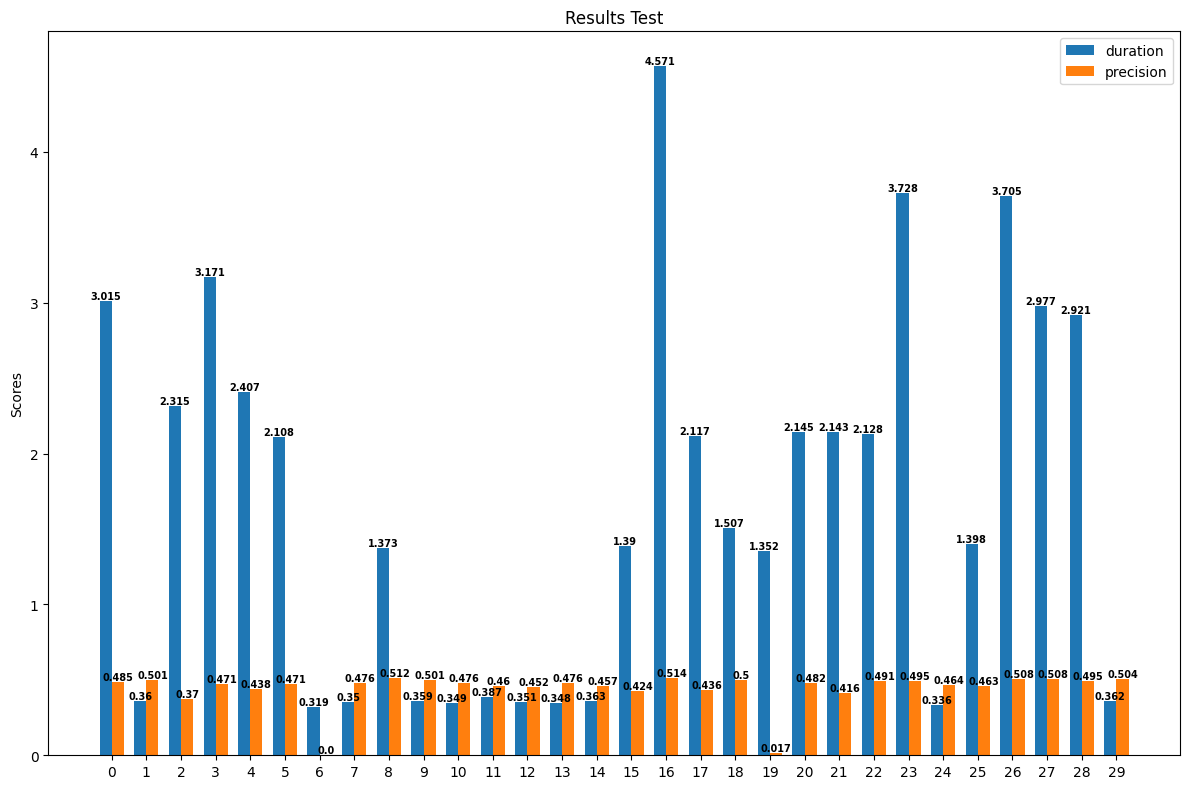

(4.570995008945465, 0.51405)
title_parms: w_cosine_similarity 0.471, w_boolean 0.917,w_BM25_b_k1_k3_baselog [0.833, 0.75, 1.75, 1.75, 10]     body_parms: w_cosine_similarity 0.677, w_boolean 0.396,w_BM25_b_k1_k3_baselog [0.732, 0.75, 1.75, 1.75, 10]


In [57]:
from nltk.metrics.scores import precision
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np


labels = result_dict.keys()
duration,precision = zip(*result_dict.values())


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, duration, width, label='duration')
rects2 = ax.bar(x + width/2, precision, width, label='precision')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Results Test')
ax.set_xticks(range(len(labels)))
ax.legend()

for bar in rects1:
  height = bar.get_height()
  ax.text(bar.get_x() + bar.get_width()/2, height, round(height,3), ha='center', va='bottom',fontsize=7,fontweight='bold')

for bar in rects2:
  height = bar.get_height()
  ax.text(bar.get_x() + bar.get_width()/2, height, round(height,3), ha='center', va='bottom',fontsize=7,fontweight='bold')
fig.tight_layout()

plt.show()
max_key = max(result_dict, key = lambda x: result_dict.get(x)[1])


print(result_dict[max_key])
print(max_key)

## **Test search**

In [99]:

# url = 'http://35.232.59.3:8080'
# place the domain you got from ngrok or GCP IP below. 


qs_res = []
for q, true_wids in queries.items():
  duration, ap = None, None
  t_start = time()
  try:
    res = requests.get(url + '/search', {'query': q}, timeout=35)
    duration = time() - t_start
    if res.status_code == 200:
      pred_wids, _ = zip(*res.json())
      ap = average_precision(true_wids, pred_wids)
  except:
    pass
  
  qs_res.append((q, duration, ap))
  


In [55]:
qs_res

[('best marvel movie', 0.3594245910644531, 0.0),
 ('How do kids come to world?', 0.4736618995666504, 0.135),
 ('Information retrieval', 0.33142662048339844, 0.923),
 ('LinkedIn', 0.31981968879699707, 1.0),
 ('How to make coffee?', 0.3265039920806885, 0.629),
 ('Ritalin', 0.3195364475250244, 1.0),
 ('How to make wine at home?', 0.3439347743988037, 0.0),
 ('Most expensive city in the world', 0.5450847148895264, 1.0),
 ('India', 0.34563708305358887, 0.291),
 ('how to make money fast?', 0.33281731605529785, 0.66),
 ('Netflix', 0.3196542263031006, 0.605),
 ('Apple computer', 0.3309507369995117, 0.619),
 ('The Simpsons', 0.32062387466430664, 0.406),
 ('World cup', 0.5757851600646973, 1.0),
 ('How to lose weight?', 0.32147884368896484, 0.0),
 ('Java', 0.32216525077819824, 0.402),
 ('Air Jordan', 0.36611127853393555, 1.0),
 ('how to deal with depression?', 0.3227255344390869, 0.122),
 ('How do you make gold', 0.3354151248931885, 0.046),
 ('Marijuana', 0.32027459144592285, 0.236)]

In [101]:
avg_time_pres(qs_res)

(3.524212296803792, 0.451)

In [84]:
result_dict[prams_to_string(parameters)] = avg_time_pres(qs_res)

In [96]:
result_dict 

{'title_parms: w_cosine_similarity 0, w_boolean 0,w_BM25_b_k1_k3_baselog [0, 0, 0, 0, 0]     body_parms: w_cosine_similarity 1, w_boolean 0,w_BM25_b_k1_k3_baselog [0, 0, 0, 0, 0]': (2.109978747367859,
  0.3982413793103448),
 'title_parms: w_cosine_similarity 0, w_boolean 0,w_BM25_b_k1_k3_baselog [0, 0, 0, 0, 0]     body_parms: w_cosine_similarity 0, w_boolean 1,w_BM25_b_k1_k3_baselog [0, 0, 0, 0, 0]': (1.3236300388971964,
  0.04593103448275861),
 'title_parms: w_cosine_similarity 0, w_boolean 0,w_BM25_b_k1_k3_baselog [0, 0, 0, 0, 0]     body_parms: w_cosine_similarity 0.5, w_boolean 0.5,w_BM25_b_k1_k3_baselog [0, 0, 0, 0, 0]': (2.897495651245117,
  0.4686206896551724)}

## **Test search_body**

In [47]:
qs_res = []
for q, true_wids in queries.items():
  duration, ap = None, None
  t_start = time()
  try:
    res = requests.get(url + '/search_body', {'query': q}, timeout=35)
    duration = time() - t_start
    if res.status_code == 200:
      pred_wids, _ = zip(*res.json())
      ap = average_precision(true_wids, pred_wids)
  except:
    pass
  
  qs_res.append((q, duration, ap))

In [ ]:
qs_res

In [48]:
avg_time_pres(qs_res)

(1.445989696184794, 0.3982413793103448)

## **Test search_title**

In [49]:
qs_res = []
for q, true_wids in queries.items():
  duration, ap = None, None
  t_start = time()
  try:
    res = requests.get(url + '/search_title', {'query': q}, timeout=35)
    duration = time() - t_start
    if res.status_code == 200:
      pred_wids, _ = zip(*res.json())
      ap = average_precision(true_wids, pred_wids)
  except:
    pass
  
  qs_res.append((q, duration, ap))

In [ ]:
qs_res

In [50]:
avg_time_pres(qs_res)

(0.05530214309692383, 0.4911379310344828)

## **Test search_anchor**

In [4]:
qs_res = []
for q, true_wids in queries.items():
  duration, ap = None, None
  t_start = time()
  try:
    res = requests.get(url + '/search_anchor', {'query': q}, timeout=35)
    duration = time() - t_start
    if res.status_code == 200:
      pred_wids, _ = zip(*res.json())
      ap = average_precision(true_wids, pred_wids)
  except:
    pass
  
  qs_res.append((q, duration, ap))

NameError: ignored

In [22]:
qs_res

[('best marvel movie', 1.2029616832733154, 0.211),
 ('How do kids come to world?', 0.8682630062103271, None),
 ('Information retrieval', 0.3724937438964844, 0.539),
 ('LinkedIn', 0.19281625747680664, 0.0),
 ('How to make coffee?', 0.3871622085571289, 0.0),
 ('Ritalin', 0.07719063758850098, 1.0),
 ('How to make wine at home?', 0.666496992111206, 0.0),
 ('Most expensive city in the world', 1.1442947387695312, None),
 ('India', 0.5168144702911377, 0.0),
 ('how to make money fast?', 0.35771942138671875, 0.0),
 ('Netflix', 0.28501033782958984, 0.0),
 ('Apple computer', 0.3236422538757324, None),
 ('The Simpsons', 0.22041893005371094, 0.0),
 ('World cup', 0.9011344909667969, None),
 ('How to lose weight?', 0.15961432456970215, 1.0),
 ('Java', 0.2603275775909424, 0.0),
 ('Air Jordan', 0.4343099594116211, None),
 ('how to deal with depression?', 0.3039383888244629, 0.0),
 ('How do you make gold', 0.16629528999328613, None),
 ('Marijuana', 0.09459686279296875, 0.408),
 ('How to make hummus', 0.

## **Test Page Rank**

In [15]:
qs_res = []
lst = [100,200,300,565677,54656,89897]

duration, ap = None, None
t_start = time()
try:
  res = requests.post(url+'/get_pagerank',json=lst)
  duration = time() - t_start
  if res.status_code == 200:
    qs_res= res.json()
except:
  pass
  
qs_res

[[565677, 1719]]

## **Test Page View**

In [14]:
qs_res = []
lst = [100,200,300,565677,54656,89897]

duration, ap = None, None
t_start = time()
try:
  res = requests.post(url+'/get_pageview',json=lst)
  duration = time() - t_start
  if res.status_code == 200:
    qs_res= res.json()
except:
  pass
  
qs_res

[[100, 0.0],
 [200, 0.0],
 [300, 0.0],
 [565677, 1719],
 [54656, 0.0],
 [89897, 0.0]]